In [10]:
cd /tf/astromer

/tf/astromer


In [11]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import BatchNormalization, Dense, LSTM, LayerNormalization

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


from presentation.experiments.mlp_exp_1 import load_embeddings
from core.data import load_records_v2

In [12]:
# train_batches = load_embeddings('./time_embs/alcock/train', n_cls, 16)
# val_batches = load_embeddings('./time_embs/alcock/val', n_cls, 16)

In [13]:
n_cls = pd.read_csv('./data/records/ogle_20/test_objs.csv')['class'].unique().size

In [14]:
train_batches = load_records_v2('./data/records/ogle_20/train', 64,   
                             max_obs=200,
                             msk_frac=0.,
                             rnd_frac=0.,
                             same_frac=0.,
                             repeat=5,
                             is_train=True)
val_batches = load_records_v2('./data/records/ogle_20/val', 64,   
                             max_obs=200,
                             msk_frac=0.,
                             rnd_frac=0.,
                             same_frac=0.,
                             repeat=5,
                             is_train=True)

Training Mode
Training Mode


In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(200, 2)))
model.add(LSTM(128, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(128, return_sequences=False))
model.add(BatchNormalization())
model.add(Dense(n_cls))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200, 128)          67072     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 128)          512       
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1419      
Total params: 201,099
Trainable params: 200,587
Non-trainable params: 512
_________________________________________________________________


In [17]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy')

estop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

In [18]:
hist = model.fit(train_batches, 
                 epochs=1000,
                 batch_size=256,
                 callbacks=[estop],
                 validation_data=val_batches)

Epoch 1/1000


ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/input_spec.py:219 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 2, None, None)


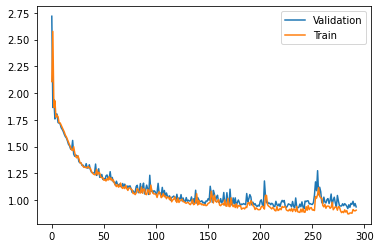

In [115]:
import matplotlib.pyplot as plt
plt.plot(hist.history['val_loss'], label='Validation')
plt.plot(hist.history['loss'], label='Train')
plt.legend()

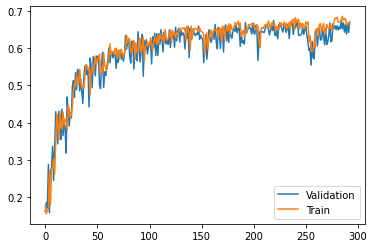

In [116]:
import matplotlib.pyplot as plt
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.plot(hist.history['accuracy'], label='Train')
plt.legend()

In [117]:
model.save('./my_model_500')

INFO:tensorflow:Assets written to: ./my_model_500/assets


## Testing

In [118]:
import tensorflow as tf
import h5py
import numpy as np

from sklearn.metrics import precision_recall_fscore_support



In [119]:
cd /tf/astromer

/tf/astromer


In [120]:
model = tf.keras.models.load_model('./my_model_500')

In [121]:
metrics = []
for i in range(1, 6):
    with open('./alcock_emb/test_emb_{}.h5'.format(i), 'rb') as file:
        hf = h5py.File(file)
        x_test_time = hf['x'][()]
        y_test = hf['y'][()]
        l_test = hf['l'][()]
        m_test = 1. - hf['m'][()]
    n_classes = len(np.unique(y_test))
    x_test = np.sum(x_test_time*m_test, 1)/l_test[:,None]
    
    indices = np.random.randint(x_test.shape[0], size=750)
    x_test_reduced = x_test[indices]
    y_test_reduced = y_test[indices]
    
    y_pred = model.predict(x_test)
    y_pred_labs = tf.argmax(y_pred, 1)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_labs, average='macro')
    metrics.append([prec, rec, f1])

In [122]:
np.mean(metrics, 0)

array([0.66200063, 0.65999467, 0.65490203])

In [123]:
np.std(metrics, 0)

array([0.00305335, 0.00351824, 0.00300953])

In [46]:

y_test_oneot = tf.one_hot(y_test, n_classes)

In [8]:
import dask.dataframe as dd
import os

In [13]:
batches = './data/embeddings/alcock_records'

In [14]:
observations = dd.read_csv(os.path.join(batches,'*.csv'))

In [16]:
observations.compute()

,oid,label,embs
0,b'1.3443.95',2,[[ 0.2846946 0.27859616 0.29226178 ... 0.2...
1,b'1.3567.1010',0,[[ 0.28489444 0.28023285 0.29222584 ... 0.2...
2,b'1.3691.32',1,[[ 0.2846132 0.27911228 0.29225758 ... 0.2...
3,b'11.8874.36',0,[[ 0.28419593 0.27802372 0.29239047 ... 0.2...
4,b'1.3564.516',2,[[ 0.28459617 0.27790824 0.29232252 ... 0.2...
...,...,...,...
15,b'15.10192.17',3,[[ 0.2842402 0.27915126 0.2923492 ... 0.2...
16,b'2.5388.1150',5,[[ 0.28462884 0.2811178 0.29225647 ... 0.2...
17,b'22.4750.504',5,[[ 0.28273726 0.28988522 0.29268172 ... 0.2...
18,b'22.4992.500',5,[[ 0.2864836 0.25984347 0.29520085 ... 0.2...
